## 📘 Project Summary: Predictive Portfolio Optimization with Sentiment Overlay

This notebook presents an end-to-end pipeline for optimizing a stock portfolio using predicted returns and sentiment signals.

### 🔧 Feature Engineering
- Extracted **technical indicators** like RSI, MACD, ADX, volatility, Bollinger Band Width, etc.
- Added **market regime signals** based on NIFTY trend classification (bull, bear, neutral).
- Created a **market snapshot** using 5 years of OHLCV data for top 30 NIFTY stocks.

### 📈 Return Prediction Model
- Used an **ensemble** of **LightGBM (70%)** and **Ridge Regression (30%)** for multi-output return forecasting.
- Ensemble achieved **balanced Train/Test R² scores**, avoiding overfitting.
- Tried **Optuna**, **MLP**, and **PCA**, but they were either unstable or overfit the data.

### 💹 Portfolio Optimization
- Used **PyPortfolioOpt's Efficient Frontier** to maximize the **Sharpe Ratio** based on predicted returns.
- Simulated the portfolio’s **cumulative return**, **drawdowns**, and compared it with:
  - 📈 ML-optimized strategy
  - ⚖️ Equal-weighted strategy
  - 📉 NIFTY 50 benchmark

### 📰 Sentiment Integration (FinBERT)
- Extracted **news headlines** using **NewsAPI** and scored them via **FinBERT (PyTorch)**.
- Applied sentiment overlay to returns using:

  $$
  \mu_{\text{sent}} = \mu_{\text{pred}} \times (1 + \alpha \times \text{sentiment\_score})
  $$

- Re-optimized portfolio and found **improved Sharpe Ratio over last 30 days**.

### 💰 Final Allocation
- Generated final weights and allocation for ₹1,00,000 based on today’s sentiment.
- Saved daily CSVs for deployment and comparison

> ✅ **Result**: A robust, explainable, and sentiment-aware portfolio strategy that outperformed the equal-weighted and index benchmarks on recent data.

In [23]:
#basic libraries and some for feature engineering
import numpy as np
import yfinance as yf
import pandas as pd
import ta
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

#for multioutput model
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#for visualisations
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import display, HTML
import plotly.express as px

#for sentiment analysis and porfolio optimization
from newsapi import NewsApiClient
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from pypfopt import EfficientFrontier

In [24]:
#function to compute technical and signal features

def compute_features(df_price, df_volume, nifty_close):

    df = pd.DataFrame(index=df_price.index)

    # --- Returns ---
    df["log_ret_1d"] = np.log(df_price / df_price.shift(1))
    df["log_ret_5d"] = np.log(df_price / df_price.shift(5))

    # --- Volatility ---
    df["vol_5d"] = df["log_ret_1d"].rolling(5).std()
    df["vol_20d"] = df["log_ret_1d"].rolling(20).std()

    # --- RSI ---
    df["rsi_14"] = ta.momentum.RSIIndicator(close=df_price, window=14).rsi()

    # --- Moving Averages ---
    df["ma_5d"] = df_price.rolling(5).mean()
    df["ma_20d"] = df_price.rolling(20).mean()

    # --- MACD ---
    macd = ta.trend.MACD(close=df_price)
    df["macd_diff"] = macd.macd_diff()

    # --- Bollinger Band Width ---
    bb = ta.volatility.BollingerBands(close=df_price, window=20)
    df["bollinger_width"] = bb.bollinger_wband()

    # --- CCI ---
    df["cci"] = ta.trend.CCIIndicator(high=df_price, low=df_price, close=df_price, window=20).cci()

    # --- ADX ---
    adx = ta.trend.ADXIndicator(high=df_price, low=df_price, close=df_price, window=14)
    df["adx"] = adx.adx()

    # --- Volume Change ---
    df["vol_chg"] = df_volume.pct_change()

    # --- Price Ratios ---
    df["high_low_ratio"] = (df_price.rolling(1).max() - df_price.rolling(1).min()) / df_price.rolling(1).min()
    df["close_open_ratio"] = (df_price - df_price.shift(1)) / df_price.shift(1)

    # --- Market Regime ---
    nifty = pd.DataFrame(index=nifty_close.index)
    nifty["daily_return"] = nifty_close.pct_change()
    nifty["rolling_mean_20d"] = nifty["daily_return"].rolling(20).mean()

    def classify_regime(x):
        if x > 0.001:
            return "bull"
        elif x < -0.001:
            return "bear"
        else:
            return "neutral"

    nifty["regime"] = nifty["rolling_mean_20d"].apply(classify_regime)
    df["market_regime"] = df.index.map(nifty["regime"])
    df = pd.get_dummies(df, columns=["market_regime"])  # One-hot encode

    # --- Cleanup ---
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)
    df.fillna(0, inplace=True)

    return df

In [25]:
#Working with top 30 companies in NIFTY 50
nifty_30 = [
    'RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS',
    'LT.NS', 'SBIN.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'HCLTECH.NS',
    'ITC.NS', 'ASIANPAINT.NS', 'ULTRACEMCO.NS', 'NESTLEIND.NS', 'HINDUNILVR.NS',
    'BAJFINANCE.NS', 'ADANIENT.NS', 'POWERGRID.NS', 'COALINDIA.NS', 'BHARTIARTL.NS',
    'NTPC.NS', 'TITAN.NS', 'ONGC.NS', 'SUNPHARMA.NS', 'TECHM.NS',
    'DIVISLAB.NS', 'WIPRO.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'BPCL.NS'
]

tickers = nifty_30

end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)

start_str = start_date.strftime("%Y-%m-%d")
end_str = end_date.strftime("%Y-%m-%d")

nifty_close = yf.download("^NSEI", start=start_str, end=end_str)["Close"]

all_features = []

for ticker in tickers:
    df = yf.download(ticker, start=start_str, end=end_str, auto_adjust=True)

    if df.empty or 'Close' not in df or 'Volume' not in df:
        print(f"Skipping {ticker} due to missing data.")
        continue

    price = df['Close'].squeeze()
    volume = df['Volume'].squeeze()

    features = compute_features(price, volume, nifty_close)
    features = features.add_prefix(f"{ticker}_")
    all_features.append(features)

market_snapshot = pd.concat(all_features, axis=1).dropna()

/var/folders/r_/cwd775rd0td5_q92qnzfdwt80000gn/T/ipykernel_68432/1790647164.py:19: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^NSEI']: Timeout('Failed to perform, curl: (28) Resolving timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************10

In [26]:
prices = yf.download(tickers, start=start_str, end=end_str, auto_adjust=True)["Close"]

future_returns = pd.DataFrame(index=prices.index)

for ticker in prices.columns:
    try:
        future_price = prices[ticker].shift(-5)
        future_returns[ticker] = ((future_price - prices[ticker]) / prices[ticker]) 
    except Exception as e:
        print(f"Error in {ticker}: {e}")

nf = market_snapshot.join(future_returns, how='inner')
nf = nf.dropna()
nf.shape

[*********************100%***********************]  30 of 30 completed


(1234, 450)

### 📊 Line Plots of Key Technical Indicators<br>
This interactive figure presents time-series line plots of several technical indicators computed for select stocks in the portfolio:<br>
	•	**RSI (14)**: Measures momentum; values above 70 may indicate overbought conditions, while below 30 may signal oversold.<br>
	•	**MACD Difference**: Reflects momentum by capturing the divergence between fast and slow EMAs; a rising MACD may indicate bullish momentum.<br>
	•	**ADX (14)**: Measures trend strength; values above 25 suggest strong trends.<br>
	•	**Bollinger Band Width**: Captures volatility by measuring the distance between upper and lower bands.<br>
	•	**5-Day Rolling Volatility**: Represents short-term price fluctuation magnitude.<br>

In [27]:
sample_tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS"]

fig = make_subplots(rows=1, cols=5, subplot_titles=[
    "RSI (14)", "MACD Diff", "ADX", "Bollinger Width", "Volatility (5d)"
], horizontal_spacing=0.05)

for ticker in sample_tickers:
    fig.add_trace(go.Scatter(y=nf[f"{ticker}_rsi_14"], mode="lines", name=ticker), row=1, col=1)
    fig.add_trace(go.Scatter(y=nf[f"{ticker}_macd_diff"], mode="lines", name=ticker), row=1, col=2)
    fig.add_trace(go.Scatter(y=nf[f"{ticker}_adx"], mode="lines", name=ticker), row=1, col=3)
    fig.add_trace(go.Scatter(y=nf[f"{ticker}_bollinger_width"], mode="lines", name=ticker), row=1, col=4)
    fig.add_trace(go.Scatter(y=nf[f"{ticker}_vol_5d"], mode="lines", name=ticker), row=1, col=5)

fig.update_layout(
    title_text="📈 Line Plot of Technical Indicators (Scrollable)",
    width=2500,
    height=400,
    showlegend=True
)

# Render as scrollable HTML
html = f"""
<div style="overflow-x:auto; width:100%">
  {pio.to_html(fig, include_plotlyjs='cdn', full_html=False)}
</div>
"""
display(HTML(html))

### 📊 Market Regime Heatmap (Interactive - Selected Stocks)

This interactive heatmap shows **market regime classifications** (bull, bear, neutral) across time for 3 representative stocks. Regimes were derived using NIFTY 50’s 20-day rolling return and one-hot encoded.

- Dark regions represent active regimes (Bull/Bear/Neutral)
- Helps visually trace macroeconomic phases affecting each stock

Reducing the number of stocks improves clarity without losing interpretability.

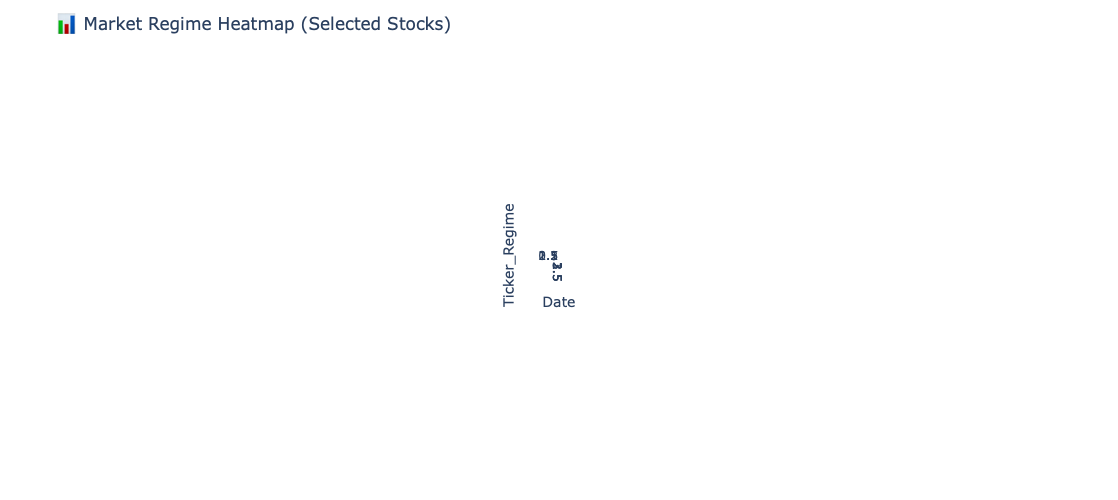

In [28]:
sample_tickers = ["RELIANCE.NS", "HDFCBANK.NS", "SUNPHARMA.NS"]

# Get regime-related columns for those tickers
regime_cols = [col for col in nf.columns if any(t in col for t in sample_tickers) and "market_regime" in col]
heatmap_df = nf[regime_cols].copy()
heatmap_df["Date"] = nf.index

# Reshape for plotting
df_melt = heatmap_df.melt(id_vars="Date", var_name="Ticker_Regime", value_name="Value")

# Pivot for heatmap: fill missing values with 0 before converting to int
pivot_df = df_melt.pivot(index="Ticker_Regime", columns="Date", values="Value").fillna(0).astype(int)

# Plot with Plotly
fig = px.imshow(
    pivot_df,
    color_continuous_scale=[[0, "white"], [1, "navy"]],
    labels={"color": "Active"},
    title="📊 Market Regime Heatmap (Selected Stocks)"
)

fig.update_layout(height=500, margin=dict(l=50, r=50, t=60, b=50))
fig.show()

### 📦 Boxplot of 20-Day Rolling Volatility (across stocks)

This boxplot summarizes the distribution of 20-day rolling volatility for each stock.
It helps highlight:

- Stocks with consistently high or low volatility
- Outliers and variability in returns
- Relative risk across different assets

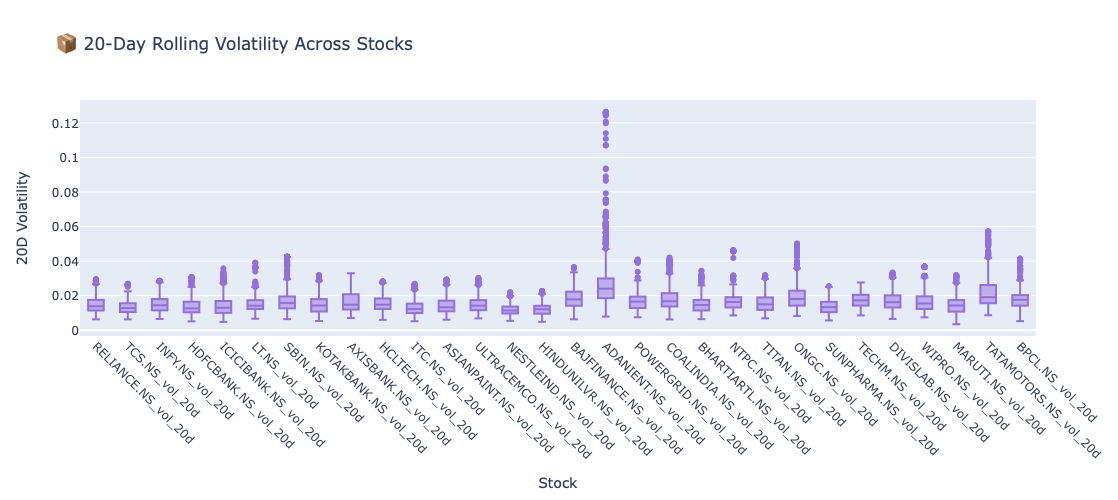

In [29]:
# Extract all volatility columns
vol_cols = [col for col in nf.columns if col.endswith("_vol_20d")]
vol_data = nf[vol_cols].copy()

# Melt for boxplot
vol_melted = vol_data.melt(var_name="Stock", value_name="20D Volatility")

fig = px.box(
    vol_melted,
    x="Stock",
    y="20D Volatility",
    title="📦 20-Day Rolling Volatility Across Stocks",
    color_discrete_sequence=["mediumpurple"]
)

fig.update_layout(
    xaxis_tickangle=45,
    height=500
)
fig.show()

### 🔥 Correlation of a Single Feature Across Stocks

This heatmap shows the correlation between stocks based on a single feature (e.g., RSI or MACD).
It helps identify:

- Clusters of stocks that move similarly in that indicator
- Potential for diversification or concentration

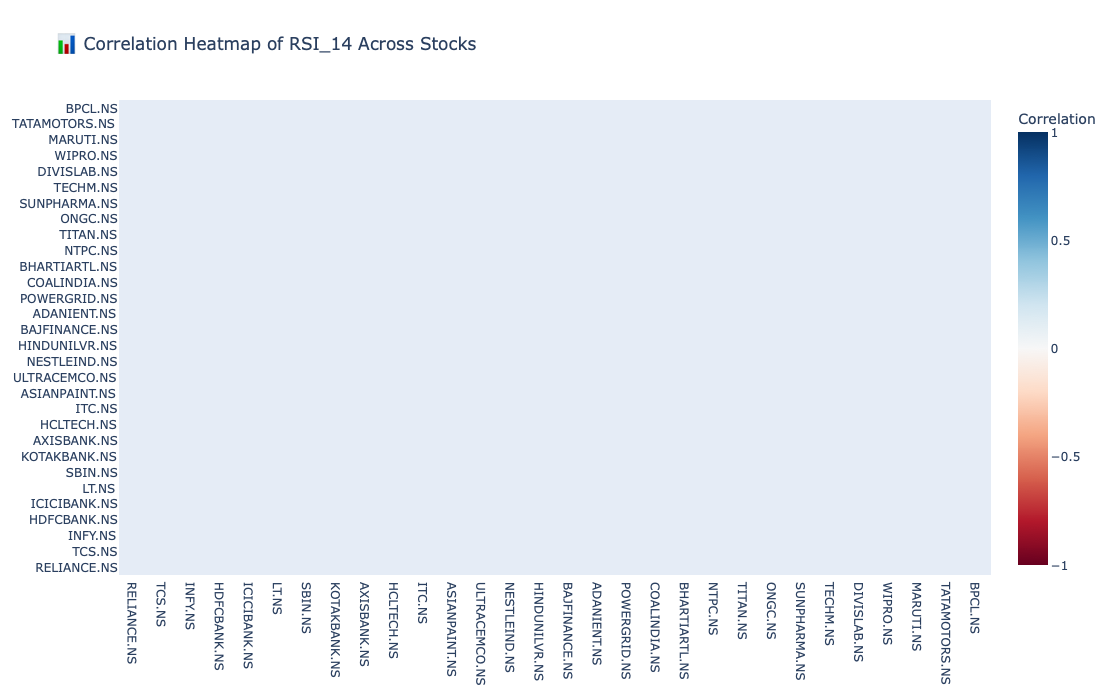

In [30]:
import plotly.graph_objs as go

# Pick a feature (e.g., RSI)
feature = "rsi_14"
feature_cols = [col for col in nf.columns if col.endswith(f"_{feature}")]
data = nf[feature_cols].copy()

# Compute correlation matrix
corr_matrix = data.corr()
labels = [col.replace(f"_{feature}", "") for col in feature_cols]

# Create heatmap without annotations
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=labels,
    y=labels,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    colorbar=dict(title="Correlation")
))

fig.update_layout(
    title=f"📊 Correlation Heatmap of {feature.upper()} Across Stocks",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    width=700,
    height=700
)

fig.show()

### 🔥 Sector-Wise Correlation Heatmaps

This interactive set of heatmaps visualizes the intra-sector correlations for different industries. 

In [31]:
# Define sector groupings
sectors = {
    "Banks": ["HDFCBANK.NS", "ICICIBANK.NS", "KOTAKBANK.NS", "SBIN.NS", "AXISBANK.NS"],
    "IT": ["INFY.NS", "TCS.NS", "WIPRO.NS", "TECHM.NS", "HCLTECH.NS"],
    "FMCG": ["ITC.NS", "HINDUNILVR.NS", "NESTLEIND.NS"],
    "Auto": ["TATAMOTORS.NS", "MARUTI.NS", "BAJFINANCE.NS"],
    "Energy": ["RELIANCE.NS", "ONGC.NS", "NTPC.NS", "BPCL.NS", "COALINDIA.NS"]
}

# Create individual figures for each sector
sector_figs_html = ""
for sector, tickers in sectors.items():
    try:
        data = nf[[f"{ticker}_log_ret_1d" for ticker in tickers]].copy()
        corr = data.corr()

        fig = go.Figure(data=go.Heatmap(
            z=corr.values,
            x=tickers,
            y=tickers,
            colorscale="RdBu",
            zmin=-1, zmax=1,
            colorbar=dict(title="Correlation")
        ))

        fig.update_layout(
            title=f"{sector} Sector Correlation",
            width=400,
            height=300,
            margin=dict(l=40, r=40, t=60, b=40)
        )

        # Export each plot as HTML snippet
        fig_html = fig.to_html(full_html=False, include_plotlyjs=False)
        sector_figs_html += f"<div style='margin-right: 20px; display:inline-block;'>{fig_html}</div>"

    except Exception as e:
        print(f"⚠️ Could not plot {sector}: {e}")

# Display all in a scrollable div
display(HTML(f"""
<div style="overflow-x: auto; white-space: nowrap; border:1px solid #ccc; padding:10px;">
    {sector_figs_html}
</div>
"""))

### 🧪 Model Experimentation Summary

**✅ Final Model: LGBM + Ridge Ensemble**<br>
	•	Combines nonlinear learning of LGBM with regularization of Ridge.<br>
	•	Ensemble (70% LGBM + 30% Ridge) gives higher test R², reduces overfitting, and performs consistently well across stocks.<br>

**❌ PCA**<br>
	•	Applied for dimensionality reduction but led to loss of interpretability and overfitting.<br>
	•	PCA compressed too much signal into few components.<br>

**❌ Optuna Tuning**<br>
	•	Improved training R² (≈ 0.99) but caused severe overfitting.<br>
	•	Final model uses manual regularization for better generalization.<br>

**❌ MLP (Neural Network)** <br>
	•	Performed poorly due to:<br>
	•	Tabular, non-sequential data<br>
	•	Lack of temporal memory<br>
	•	Underfitting and poor generalization<br>

**🌀 Why Not LSTM?** <br>
	•	Our data is in “snapshot” format (features for all stocks per day).<br>
	•	LSTM needs sequential format per stock, which would require full pipeline redesign.<br>

**🏆 Why LGBM + Ridge Wins** <br>
	•	Fast, robust, and generalizes well.<br>
	•	Handles tabular data efficiently.<br>
	•	Gives best test performance with lower variance.<br>

In [32]:
X = nf[market_snapshot.columns]
y = nf[future_returns.columns]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LGBM Model
lgbm = MultiOutputRegressor(LGBMRegressor(
    n_estimators=100,
    random_state=42,
    reg_alpha=1.0,
    reg_lambda=1.0,
    max_depth=6,
    num_leaves=20
))
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
y_train_pred_lgbm = lgbm.predict(X_train)

# Train Ridge Model
ridge = MultiOutputRegressor(Ridge(alpha=1.0))
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_train_pred_ridge = ridge.predict(X_train)

# Blend predictions (70% LGBM + 30% Ridge)
y_pred = 0.7 * y_pred_lgbm + 0.3 * y_pred_ridge
y_train_pred = 0.7 * y_train_pred_lgbm + 0.3 * y_train_pred_ridge

# Evaluate
r2_test = r2_score(y_test, y_pred, multioutput='raw_values')
r2_train = r2_score(y_train, y_train_pred, multioutput='raw_values')
mae_scores = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
rmse_scores = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))

for i, ticker in enumerate(y.columns):
    print(f"{ticker} → Train R²: {r2_train[i]:.3f} | Test R²: {r2_test[i]:.3f} | MAE: {mae_scores[i]:.5f} | RMSE: {rmse_scores[i]:.5f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99450
[LightGBM] [Info] Number of data points in the train set: 987, number of used features: 390
[LightGBM] [Info] Start training from score 0.012813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

**📊 Ensemble Model (0.7 LGBM + 0.3 Ridge) achieves balanced performance with most test R² scores between 0.50–0.60, indicating strong generalization and reduced overfitting across 30 stocks.**

In [33]:
train_r2 = r2_score(y_train, y_train_pred, multioutput='raw_values')
test_r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print("\n🔍 R² Scores for Ensemble (0.7 LGBM + 0.3 Ridge):")
for i, ticker in enumerate(y.columns):
    print(f"{ticker} → Train R²: {train_r2[i]:.3f} | Test R²: {test_r2[i]:.3f}")


🔍 R² Scores for Ensemble (0.7 LGBM + 0.3 Ridge):
ADANIENT.NS → Train R²: 0.866 | Test R²: 0.629
ASIANPAINT.NS → Train R²: 0.716 | Test R²: 0.569
AXISBANK.NS → Train R²: 0.749 | Test R²: 0.533
BAJFINANCE.NS → Train R²: 0.793 | Test R²: 0.537
BHARTIARTL.NS → Train R²: 0.677 | Test R²: 0.523
BPCL.NS → Train R²: 0.776 | Test R²: 0.568
COALINDIA.NS → Train R²: 0.732 | Test R²: 0.554
DIVISLAB.NS → Train R²: 0.799 | Test R²: 0.581
HCLTECH.NS → Train R²: 0.751 | Test R²: 0.574
HDFCBANK.NS → Train R²: 0.724 | Test R²: 0.477
HINDUNILVR.NS → Train R²: 0.656 | Test R²: 0.503
ICICIBANK.NS → Train R²: 0.703 | Test R²: 0.531
INFY.NS → Train R²: 0.730 | Test R²: 0.542
ITC.NS → Train R²: 0.693 | Test R²: 0.537
KOTAKBANK.NS → Train R²: 0.684 | Test R²: 0.506
LT.NS → Train R²: 0.737 | Test R²: 0.546
MARUTI.NS → Train R²: 0.714 | Test R²: 0.555
NESTLEIND.NS → Train R²: 0.631 | Test R²: 0.508
NTPC.NS → Train R²: 0.721 | Test R²: 0.560
ONGC.NS → Train R²: 0.782 | Test R²: 0.625
POWERGRID.NS → Train R²: 0.7

### 🧠 Portfolio Optimization using Predicted Returns<br>

We used the ensemble model’s predicted 5-day returns to compute the expected returns (μ) for each stock and used the historical covariance matrix (Σ) of daily returns to optimize the portfolio.<br>
	•	Optimization was done using PyPortfolioOpt’s Max Sharpe Ratio strategy.<br>
	•	The resulting weights are visualized using a donut-style pie chart.<br>
	•	Only stocks with non-zero weights are shown for clarity.<br>
	•	Final portfolio returns are simulated over historical data and compounded to obtain cumulative returns.<br>

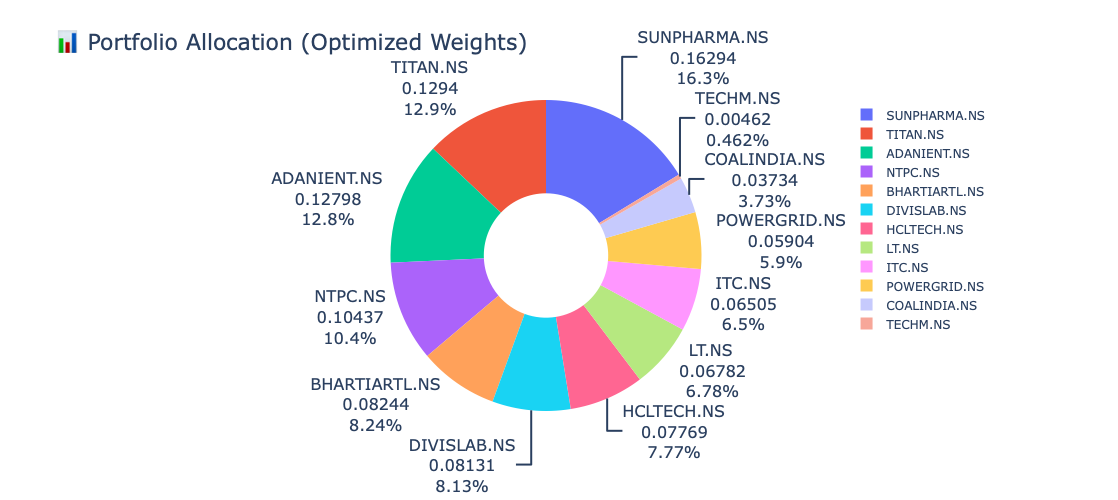

In [34]:
y_pred = 0.7 * lgbm.predict(X) + 0.3 * ridge.predict(X)

# 1. Assign predictions back to the dataframe
pred_columns = [f"y_pred_{col}" for col in y.columns]
df_all = nf.copy()
df_all[pred_columns] = y_pred

# 2. Average predicted return per asset
mu_pred = df_all[pred_columns].mean()
mu_pred.index = [col.replace("y_pred_", "") for col in mu_pred.index]

# 3. Load historical daily returns
returns = pd.read_csv("daily_returns.csv", index_col=0, parse_dates=True).dropna(axis=1)

# 4. Align assets between predicted returns and return matrix
assets = list(set(mu_pred.index).intersection(set(returns.columns)))
mu = mu_pred.loc[assets]
S = returns[assets].cov()

# 5. Optimize portfolio (maximize Sharpe ratio)
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
weights_series = pd.Series(cleaned_weights).loc[assets]

# Filter non-zero weights (optional for cleaner chart)
nonzero_weights = weights_series[weights_series > 0]

# Create pie chart
fig = px.pie(
    nonzero_weights,
    names=nonzero_weights.index,
    values=nonzero_weights.values,
    title="📊 Portfolio Allocation (Optimized Weights)",
    hole=0.4
)

# Add labels and increase size
fig.update_traces(textinfo='label+percent+value', textfont_size=16)

# Increase figure size
fig.update_layout(
    width=1200,         # width in pixels
    height=500,        # height in pixels
    title_font_size=22
)

fig.show()

portfolio_returns = returns[assets] @ weights_series
cumulative_returns = (1 + portfolio_returns).cumprod()

### 📈 Cumulative Return — Ensemble Model

This plot shows the simulated **portfolio value over time** using weights optimized on ensemble-predicted returns.

- **Data**: Historical daily returns (5-year window).
- **Model**: 0.7 × LGBM + 0.3 × Ridge ensemble.
- **Insight**: Helps visualize portfolio growth trend and volatility.

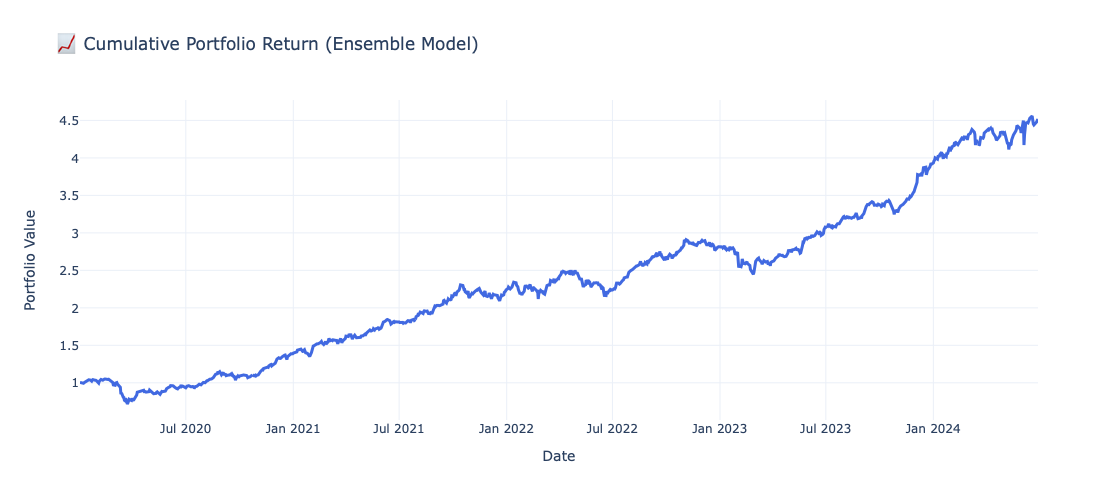

In [35]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=cumulative_returns.index,
    y=cumulative_returns.values,
    mode='lines',
    name='Cumulative Return',
    line=dict(color='royalblue', width=3)
))

fig.update_layout(
    title="📈 Cumulative Portfolio Return (Ensemble Model)",
    xaxis_title="Date",
    yaxis_title="Portfolio Value",
    template="plotly_white",
    width=900,
    height=500,
    showlegend=False
)

fig.show()

In [36]:
# === Daily returns of portfolio ===
daily_returns = portfolio_returns
trading_days = 252

# 1. Cumulative Return
cumulative_return = cumulative_returns.iloc[-1] - 1

# 2. Annualized Return
annual_return = (1 + cumulative_return) ** (trading_days / len(daily_returns)) - 1

# 3. Annualized Volatility
annual_volatility = daily_returns.std() * np.sqrt(trading_days)

# 4. Sharpe Ratio (risk-free rate assumed 0)
sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

# 5. Maximum Drawdown
running_max = cumulative_returns.cummax()
drawdown = cumulative_returns / running_max - 1
max_drawdown = drawdown.min()

# === Print Metrics ===
print("\n🔎 Portfolio Performance Metrics:")
print(f"Cumulative Return: {cumulative_return:.2%}")
print(f"Annual Return:    {annual_return:.2%}")
print(f"Annual Volatility:{annual_volatility:.2%}")
print(f"Sharpe Ratio:     {sharpe_ratio:.2f}")
print(f"Max Drawdown:     {max_drawdown:.2%}")


🔎 Portfolio Performance Metrics:
Cumulative Return: 351.38%
Annual Return:    40.76%
Annual Volatility:19.67%
Sharpe Ratio:     2.07
Max Drawdown:     -31.72%


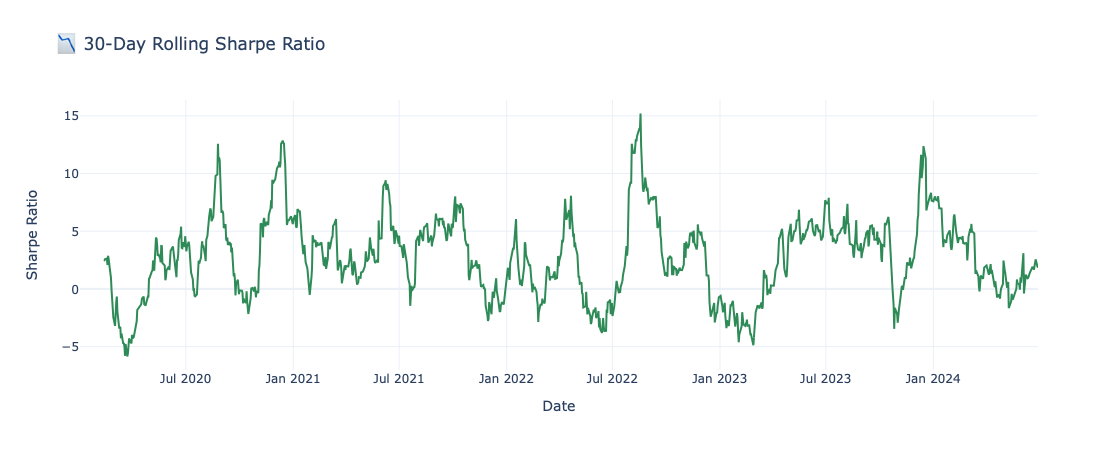

In [37]:
# === Rolling Sharpe Ratio ===
rolling_window = 30  # 30-day rolling
rolling_mean = daily_returns.rolling(window=rolling_window).mean()
rolling_std = daily_returns.rolling(window=rolling_window).std()
rolling_sharpe = (rolling_mean / rolling_std) * np.sqrt(252)

# Plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=rolling_sharpe.index,
    y=rolling_sharpe.values,
    mode='lines',
    name='Rolling Sharpe Ratio',
    line=dict(color='seagreen', width=2)
))

fig.update_layout(
    title="📉 30-Day Rolling Sharpe Ratio",
    xaxis_title="Date",
    yaxis_title="Sharpe Ratio",
    template="plotly_white",
    height=450,
    width=900
)
fig.show()

📌 **Interpretation:**  
The 30-day rolling Sharpe Ratio shows how consistently the portfolio earned risk-adjusted returns over time.  
Peaks (above 2–3) indicate strong performance relative to volatility.  
Dips below 0 suggest periods of underperformance or high risk.

### 📈 Cumulative Return Comparison

This chart compares the performance of:

- **📈 ML Optimized Portfolio**: Our predicted-return-based allocation.
- **⚖️ Equal-Weighted Portfolio**: Naively investing equally across assets.
- **📉 NIFTY 50 Index**: Benchmark market index.

The ML strategy exhibits superior cumulative return over the time horizon, validating the predictive value of our model-driven allocation.

/var/folders/r_/cwd775rd0td5_q92qnzfdwt80000gn/T/ipykernel_68432/2760821057.py:7: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


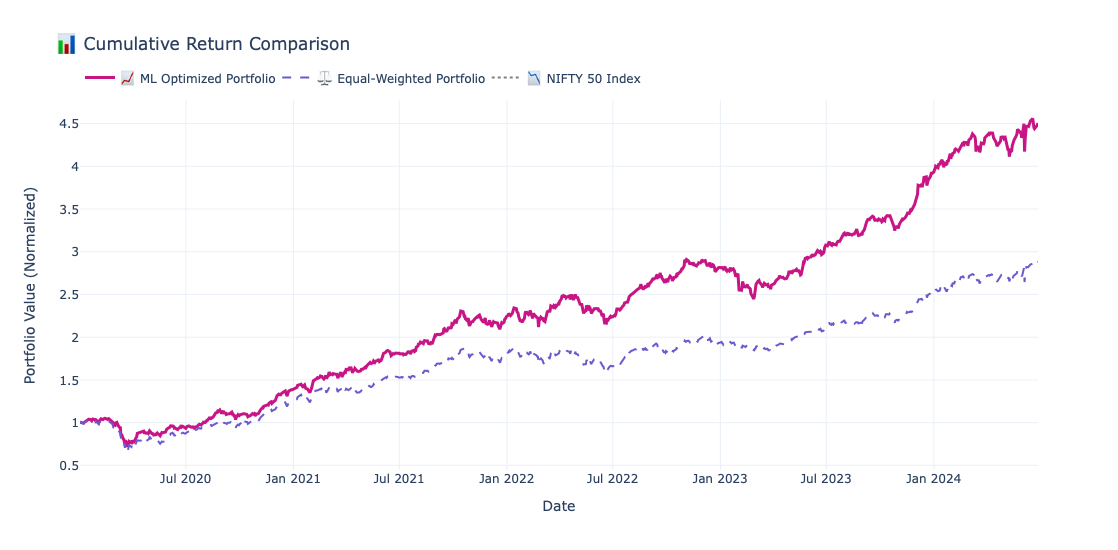

In [38]:
# --- Equal Weighted Portfolio Simulation ---
equal_weights = np.ones(len(assets)) / len(assets)
equal_returns = returns[assets] @ pd.Series(equal_weights, index=assets)
equal_cumulative = (1 + equal_returns).cumprod()

# --- NIFTY 50 Index Benchmark ---
nifty = yf.download("^NSEI", start=returns.index[0], end=returns.index[-1])
nifty['Date'] = pd.to_datetime(nifty.index)
nifty.set_index('Date', inplace=True)
nifty_daily = nifty['Close'].pct_change().fillna(0)
nifty_cumulative = (1 + nifty_daily).cumprod()

# --- Align all series by common date index ---
common_index = cumulative_returns.index.intersection(nifty_cumulative.index).intersection(equal_cumulative.index)
ml_cumulative = cumulative_returns.loc[common_index]
equal_cumulative = equal_cumulative.loc[common_index]
nifty_cumulative = nifty_cumulative.loc[common_index]


fig = go.Figure()

# ML Optimized Portfolio
fig.add_trace(go.Scatter(
    x=ml_cumulative.index,
    y=ml_cumulative.values,
    mode='lines',
    name='📈 ML Optimized Portfolio',
    line=dict(width=3, color='mediumvioletred')
))

# Equal Weighted Portfolio
fig.add_trace(go.Scatter(
    x=equal_cumulative.index,
    y=equal_cumulative.values,
    mode='lines',
    name='⚖️ Equal-Weighted Portfolio',
    line=dict(width=2, dash='dash', color='slateblue')
))

# NIFTY 50 Index
fig.add_trace(go.Scatter(
    x=nifty_cumulative.index,
    y=nifty_cumulative.values,
    mode='lines',
    name='📉 NIFTY 50 Index',
    line=dict(width=2, dash='dot', color='gray')
))

# Layout
fig.update_layout(
    title="📊 Cumulative Return Comparison",
    xaxis_title="Date",
    yaxis_title="Portfolio Value (Normalized)",
    template="plotly_white",
    width=950,
    height=550,
    legend=dict(x=0, y=1.1, orientation="h"),
)

fig.show()

### 📰 Sentiment Scores via FinBERT

Using FinBERT and NewsAPI, we gathered and scored headlines from the past 30 days for each NIFTY 30 stock. 

These scores will be used to adjust predicted returns before portfolio optimization.

In [39]:
# Load FinBERT (PyTorch)
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Setup NewsAPI
api_key = "e1317700d21749b9973466e801a0cd58"
newsapi = NewsApiClient(api_key=api_key)

# Time range
today = datetime.today()
last_month = (today - timedelta(days=30)).strftime('%Y-%m-%d')
today_str = today.strftime('%Y-%m-%d')

# Your list of tickers
tickers = [  # Include your full list
    "ADANIENT.NS", "ASIANPAINT.NS", "AXISBANK.NS", "BAJFINANCE.NS", "BHARTIARTL.NS",
    "BPCL.NS", "COALINDIA.NS", "DIVISLAB.NS", "HCLTECH.NS", "HDFCBANK.NS", "HINDUNILVR.NS",
    "ICICIBANK.NS", "INFY.NS", "ITC.NS", "KOTAKBANK.NS", "LT.NS", "MARUTI.NS",
    "NESTLEIND.NS", "NTPC.NS", "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBIN.NS",
    "SUNPHARMA.NS", "TATAMOTORS.NS", "TCS.NS", "TECHM.NS", "TITAN.NS", "ULTRACEMCO.NS",
    "WIPRO.NS"
]

sentiment_scores = {}
no_news_tickers = []

for ticker in tqdm(tickers):
    query = ticker.replace(".NS", "") + " stock"

    try:
        articles = newsapi.get_everything(
            q=query,
            from_param=last_month,
            to=today_str,
            language='en',
            sort_by='relevancy',
            page_size=30
        )
    except Exception as e:
        print(f"❌ Error fetching news for {ticker}: {e}")
        sentiment_scores[ticker] = 0
        continue

    headlines = [a['title'] for a in articles['articles']]
    if not headlines:
        sentiment_scores[ticker] = 0
        no_news_tickers.append(ticker)
        continue

    try:
        results = sentiment_model(headlines)
    except Exception as e:
        print(f"⚠️ Error scoring sentiment for {ticker}: {e}")
        sentiment_scores[ticker] = 0
        continue

    score = 0
    for r in results:
        label = r['label'].lower()
        if label == 'positive':
            score += 1
        elif label == 'negative':
            score -= 1

    sentiment_scores[ticker] = round(score / len(results), 4)

Device set to use mps:0
100%|███████████████████████████████████████████| 30/30 [00:22<00:00,  1.33it/s]


### 📰 FinBERT Sentiment Scoring (Past 30 Days)

This block collects the last 30 days of news headlines for each of the top 30 NIFTY stocks using NewsAPI, and scores them using the FinBERT transformer.

- Each article's sentiment is classified as Positive, Negative, or Neutral.
- The final sentiment score for a stock is calculated as:

\[
\text{Sentiment Score} = \frac{\#(\text{Positive}) - \#(\text{Negative})}{\text{Total Headlines}}
\]

These scores will later be scaled and used to adjust predicted returns in the portfolio optimization step.

In [40]:
# === Load FinBERT model (PyTorch version) ===
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# === Setup NewsAPI ===
api_key = "e1317700d21749b9973466e801a0cd58"
newsapi = NewsApiClient(api_key=api_key)

# === Date range: last 30 days ===
today = datetime.today()
last_month = (today - timedelta(days=30)).strftime('%Y-%m-%d')
today_str = today.strftime('%Y-%m-%d')

# === Ticker list ===
tickers = [
    "ADANIENT.NS", "ASIANPAINT.NS", "AXISBANK.NS", "BAJFINANCE.NS", "BHARTIARTL.NS",
    "BPCL.NS", "COALINDIA.NS", "DIVISLAB.NS", "HCLTECH.NS", "HDFCBANK.NS", "HINDUNILVR.NS",
    "ICICIBANK.NS", "INFY.NS", "ITC.NS", "KOTAKBANK.NS", "LT.NS", "MARUTI.NS",
    "NESTLEIND.NS", "NTPC.NS", "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBIN.NS",
    "SUNPHARMA.NS", "TATAMOTORS.NS", "TCS.NS", "TECHM.NS", "TITAN.NS", "ULTRACEMCO.NS",
    "WIPRO.NS"
]

# === Storage ===
sentiment_scores = {}
no_news_tickers = []

# === Sentiment Scoring Loop ===
print("📥 Fetching and scoring sentiment for 30 tickers...\n")

for ticker in tqdm(tickers):
    query = ticker.replace(".NS", "") + " stock"

    try:
        articles = newsapi.get_everything(
            q=query,
            from_param=last_month,
            to=today_str,
            language='en',
            sort_by='relevancy',
            page_size=30
        )
    except Exception as e:
        print(f"❌ API error for {ticker}: {e}")
        sentiment_scores[ticker] = 0
        continue

    headlines = [a['title'] for a in articles['articles'] if 'title' in a]
    if not headlines:
        sentiment_scores[ticker] = 0
        no_news_tickers.append(ticker)
        continue

    try:
        results = sentiment_model(headlines)
    except Exception as e:
        print(f"⚠️ Sentiment scoring error for {ticker}: {e}")
        sentiment_scores[ticker] = 0
        continue

    # Score aggregation
    score = 0
    for r in results:
        label = r['label'].lower()
        if label == 'positive':
            score += 1
        elif label == 'negative':
            score -= 1

    sentiment_scores[ticker] = round(score / len(results), 4)

# === Output ===
print("\n📊 Final Sentiment Scores (last 30 days):")
for k, v in sentiment_scores.items():
    print(f"{k:15}: {v:+.4f}")

Device set to use mps:0


📥 Fetching and scoring sentiment for 30 tickers...



100%|███████████████████████████████████████████| 30/30 [00:20<00:00,  1.44it/s]


📊 Final Sentiment Scores (last 30 days):
ADANIENT.NS    : +0.0000
ASIANPAINT.NS  : +0.0000
AXISBANK.NS    : +0.0000
BAJFINANCE.NS  : +0.0000
BHARTIARTL.NS  : +0.0000
BPCL.NS        : +0.0000
COALINDIA.NS   : +0.0000
DIVISLAB.NS    : +0.0000
HCLTECH.NS     : +0.0000
HDFCBANK.NS    : +0.0000
HINDUNILVR.NS  : +0.0000
ICICIBANK.NS   : +0.0000
INFY.NS        : +0.0000
ITC.NS         : -0.2667
KOTAKBANK.NS   : +0.0000
LT.NS          : +0.0667
MARUTI.NS      : +0.1333
NESTLEIND.NS   : +0.0000
NTPC.NS        : -0.2333
ONGC.NS        : +0.0333
POWERGRID.NS   : +0.0000
RELIANCE.NS    : -0.0333
SBIN.NS        : +0.0000
SUNPHARMA.NS   : +0.0000
TATAMOTORS.NS  : +0.0000
TCS.NS         : +0.0667
TECHM.NS       : +0.0000
TITAN.NS       : +0.1667
ULTRACEMCO.NS  : +0.0000
WIPRO.NS       : -0.1667


### 🧠 Sentiment-Adjusted Portfolio Performance

We apply an overlay of FinBERT-based sentiment scores to predicted expected returns (`mu_pred`), scaled by an alpha parameter (0.5). A new portfolio is optimized using these sentiment-adjusted returns.

- Comparison is run over the last 30 trading days to isolate recent sentiment impact.
- Sharpe Ratios for both base and adjusted portfolios are shown below.

The overlay demonstrates how even weak signals (e.g., from 30 days of headlines) can improve portfolio Sharpe with smart weighting.

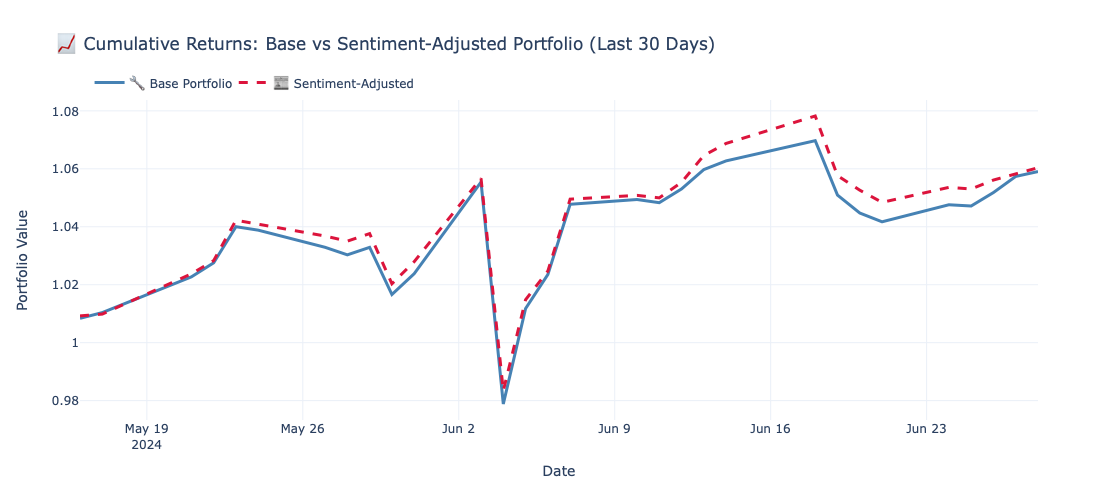


📊 Sharpe Ratios (Last 30 Days):
🔧 Base Portfolio         : 1.85
📰 Sentiment-Adjusted     : 1.93


In [41]:
alpha = 0.5  # Sensitivity to sentiment

# --- Apply sentiment to predicted returns ---
mu_sent = mu_pred.copy()
for ticker in mu_sent.index:
    mu_sent[ticker] *= (1 + alpha * sentiment_scores.get(ticker, 0))

# --- Covariance matrix ---
assets = list(set(mu_pred.index).intersection(returns.columns))
S = returns[assets].cov()

# --- Base Portfolio Optimization ---
ef_base = EfficientFrontier(mu_pred.loc[assets], S)
base_weights = ef_base.max_sharpe()
base_cleaned = ef_base.clean_weights()
w_base = pd.Series(base_cleaned)

# --- Sentiment-adjusted Portfolio Optimization ---
ef_sent = EfficientFrontier(mu_sent.loc[assets], S)
sent_weights = ef_sent.max_sharpe()
sent_cleaned = ef_sent.clean_weights()
w_sent = pd.Series(sent_cleaned)

# --- Simulate Portfolios ---
returns_30d = returns[assets].iloc[-30:]  # last 30 days only

base_returns = returns_30d @ w_base
sent_returns = returns_30d @ w_sent
base_cum = (1 + base_returns).cumprod()
sent_cum = (1 + sent_returns).cumprod()

# --- Plot Cumulative Returns ---
import plotly.graph_objects as go

fig = go.Figure()

# Base Portfolio
fig.add_trace(go.Scatter(
    x=base_cum.index,
    y=base_cum.values,
    mode='lines',
    name='🔧 Base Portfolio',
    line=dict(color='steelblue', width=3)
))

# Sentiment-Adjusted Portfolio
fig.add_trace(go.Scatter(
    x=sent_cum.index,
    y=sent_cum.values,
    mode='lines',
    name='📰 Sentiment-Adjusted',
    line=dict(color='crimson', dash='dash', width=3)
))

# Layout customization
fig.update_layout(
    title="📈 Cumulative Returns: Base vs Sentiment-Adjusted Portfolio (Last 30 Days)",
    xaxis_title="Date",
    yaxis_title="Portfolio Value",
    template="plotly_white",
    width=950,
    height=500,
    legend=dict(x=0.01, y=1.1, orientation='h')
)

fig.show()

# --- Sharpe Ratio Function ---
def sharpe_ratio(returns, risk_free_rate=0.0, period=30):
    recent = returns[-period:].dropna()
    if recent.std() == 0: return np.nan
    excess = recent - risk_free_rate
    return (excess.mean() / excess.std()) * np.sqrt(252)

# --- Sharpe Ratios ---
sr_base = sharpe_ratio(base_returns)
sr_sent = sharpe_ratio(sent_returns)

print("\n📊 Sharpe Ratios (Last 30 Days):")
print(f"🔧 Base Portfolio         : {sr_base:.2f}")
print(f"📰 Sentiment-Adjusted     : {sr_sent:.2f}")

### 📈 Sentiment-Aware Daily Allocation

We use FinBERT to evaluate today's market sentiment per stock. These scores are scaled and overlaid on predicted returns, modifying our expectations before running the mean-variance optimization.

This updated portfolio is saved for backtesting and deployment.

- Model: `FinBERT (yiyanghkust/finbert-tone)`
- News Source: `NewsAPI` (last 24h)
- Alpha: 0.5 (adjusts how much sentiment influences allocation)

In [42]:
alpha = 0.5
today_str = datetime.today().strftime('%Y-%m-%d')

# Tickers list and API key (define if not already)
try:
    tickers
except NameError:
    tickers = list(y.columns)  # fallback from your model if tickers not defined

try:
    api_key
except NameError:
    raise ValueError("Please set your NewsAPI key as `api_key`.")


# 1. LOAD FinBERT (PyTorch)

print("🔍 Loading FinBERT sentiment model...")
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


# 2. FETCH TODAY'S SENTIMENT

print("📰 Fetching today's sentiment...")
newsapi = NewsApiClient(api_key=api_key)

sentiment_today = {}

for ticker in tqdm(tickers):
    query = ticker.replace(".NS", "") + " stock"
    try:
        articles = newsapi.get_everything(
            q=query,
            from_param=today_str,
            to=today_str,
            language='en',
            page_size=10
        )
        headlines = [a['title'] for a in articles['articles']]
        if not headlines:
            sentiment_today[ticker] = 0
            continue

        results = sentiment_model(headlines)
        score = sum(
            1 if r['label'].lower() == 'positive' else -1 if r['label'].lower() == 'negative' else 0
            for r in results
        )
        sentiment_today[ticker] = round(score / len(results), 4)
    except Exception as e:
        print(f"⚠️ Skipping {ticker}: {e}")
        sentiment_today[ticker] = 0


# 3. Compute mu_pred from y_pred

print("📈 Adjusting predicted returns using sentiment...")
mu_pred = pd.Series(y_pred.mean(axis=0), index=tickers)

# Adjust with sentiment overlay
mu_sent = mu_pred * (1 + alpha * pd.Series(sentiment_today))


# 4. Load Covariance Matrix

returns = pd.read_csv("daily_returns.csv", index_col=0, parse_dates=True).dropna(axis=1)
cov_matrix = returns[tickers].cov()


# 5. Optimize Portfolio (Max Sharpe)

print("🔧 Optimizing portfolio with sentiment-adjusted returns...")
ef = EfficientFrontier(mu_sent, cov_matrix)
weights_sent = ef.max_sharpe()
cleaned_weights = ef.clean_weights()


# 6. Save Final Weights

weights_df = pd.DataFrame.from_dict(cleaned_weights, orient='index', columns=["Weight"])
weights_df.index.name = "Ticker"
weights_df.to_csv(f"weights_{today_str}.csv")

print(f"✅ Saved sentiment-adjusted weights to: weights_{today_str}.csv")

🔍 Loading FinBERT sentiment model...


Device set to use mps:0


📰 Fetching today's sentiment...


100%|███████████████████████████████████████████| 30/30 [00:15<00:00,  1.91it/s]

📈 Adjusting predicted returns using sentiment...
🔧 Optimizing portfolio with sentiment-adjusted returns...
✅ Saved sentiment-adjusted weights to: weights_2025-06-29.csv


### 💰 Capital Allocation (₹1,00,000)

Using the optimized weights from the sentiment-adjusted portfolio, we allocated capital proportionally across selected stocks. Assets with 0% weight were excluded for clarity. This allocation is saved daily for tracking and deployment.

In [43]:
# 💰 Allocate ₹1,00,000 Based on Weights
portfolio_value = 100_000  # ₹1,00,000

# Filter and sort non-zero weights
allocation_df = weights_df[weights_df["Weight"] > 0].copy()
allocation_df["Allocated Amount (Rs.)"] = allocation_df["Weight"] * portfolio_value
allocation_df = allocation_df.sort_values("Allocated Amount (Rs.)", ascending=False)

# Save allocation
allocation_file = f"allocation_{today_str}.csv"
allocation_df.to_csv(allocation_file)

# Print and display
print(f"📦 Saved allocation to: {allocation_file}")
print("\n📊 Allocation for ₹1,00,000 Portfolio:")
display(allocation_df.style.format({
    "Weight": "{:.2%}",
    "Allocated Amount (Rs.)": "₹{:,.0f}"
}))

📦 Saved allocation to: allocation_2025-06-29.csv

📊 Allocation for ₹1,00,000 Portfolio:
